The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 97.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successf

# Adadelta
:label:`sec_adadelta`


Adadelta是AdaGrad的另一种变体（ :numref:`sec_adagrad`），
主要区别在于前者减少了学习率适应坐标的数量。
此外，广义上Adadelta被称为没有学习率，因为它使用变化量本身作为未来变化的校准。
Adadelta算法是在 :cite:`Zeiler.2012`中提出的。

## Adadelta算法

简而言之，Adadelta使用两个状态变量，$\mathbf{s}_t$用于存储梯度二阶导数的泄露平均值，$\Delta\mathbf{x}_t$用于存储模型本身中参数变化二阶导数的泄露平均值。请注意，为了与其他出版物和实现的兼容性，我们使用作者的原始符号和命名（没有其它真正理由让大家使用不同的希腊变量来表示在动量法、AdaGrad、RMSProp和Adadelta中用于相同用途的参数）。

以下是Adadelta的技术细节。鉴于参数du jour是$\rho$，我们获得了与 :numref:`sec_rmsprop`类似的以下泄漏更新：

$$\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}$$

与 :numref:`sec_rmsprop`的区别在于，我们使用重新缩放的梯度$\mathbf{g}_t'$执行更新，即

$$\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}$$

那么，调整后的梯度$\mathbf{g}_t'$是什么？我们可以按如下方式计算它：

$$\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}$$

**其中$\Delta \mathbf{x}_{t-1}$是重新缩放梯度的平方$\mathbf{g}_t'$的泄漏平均值。**我们将$\Delta \mathbf{x}_{0}$初始化为$0$，然后在每个步骤中使用$\mathbf{g}_t'$更新它，即

$$\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}$$

和$\epsilon$（例如$10^{-5}$这样的小值）是为了保持数字稳定性而加入的。

## 代码实现

Adadelta需要为每个变量维护两个状态变量，即$\mathbf{s}_t$和$\Delta\mathbf{x}_t$。这将产生以下实现。


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-placeupdatesvia[:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

对于每次参数更新，选择$\rho = 0.9$相当于10个半衰期。由此我们得到：


loss: 0.247, 0.142 sec/epoch


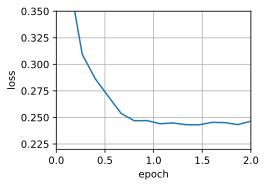

In [2]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

为了简洁实现，我们只需使用高级API中的Adadelta算法。


loss: 0.244, 0.122 sec/epoch


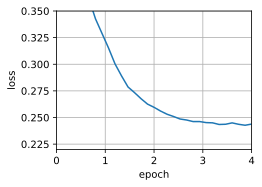

In [3]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

## 小结

* Adadelta没有学习率参数。相反，它使用参数本身的变化率来调整学习率。
* Adadelta需要两个状态变量来存储梯度的二阶导数和参数的变化。
* Adadelta使用泄漏的平均值来保持对适当统计数据的运行估计。

## 练习

1. 调整$\rho$的值，会发生什么？
1. 展示如何在不使用$\mathbf{g}_t'$的情况下实现算法。为什么这是个好主意？
1. Adadelta真的是学习率为0吗？能找到Adadelta无法解决的优化问题吗？
1. 将Adadelta的收敛行为与AdaGrad和RMSProp进行比较。


[Discussions](https://discuss.d2l.ai/t/5772)
